In [ ]:
# Komórka 1: wczytanie danych
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = r'Data\Dane0003-Volt.txt'
df = pd.read_csv(file_path, sep='\s+', header=None, names=['x_v', 'y_v', 'z_v'])

# Konwersja jednostek: Volt -> cm
df['x'] = df['x_v'] / 1.43
df['y'] = df['y_v'] / 1.43
df['z'] = df['z_v'] / 1.0

# Wstępna lokalizacja PP za pomocą histogramu 3D
hist, edges = np.histogramdd(df[['x', 'y', 'z']].values, bins=100)
max_bin = np.unravel_index(hist.argmax(), hist.shape)
pp_approx = [edges[i][max_bin[i]] for i in range(3)]

print(f"Przybliżone współrzędne PP (histogram): {pp_approx}")

# Obliczenie odległości od przybliżonego centrum i wstępne oznaczanie punktów bliskich PP
df['dist_to_pp'] = np.sqrt((df['x'] - pp_approx[0])**2 + 
                           (df['y'] - pp_approx[1])**2 + 
                           (df['z'] - pp_approx[2])**2)
df['is_near_pp'] = df['dist_to_pp'] < 0.1

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\szymo\AppData\Local\Temp\ipykernel_25276\1665748022.py:8: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, names=['x_v', 'y_v', 'z_v'])


Przybliżone współrzędne PP (histogram): [0.40693146853146867, 0.19942097902097888, 0.3515999999999997]


In [ ]:
# Komórka 2: Wyznaczenie centroidu PP za pomocą ML (DBSCAN)
from sklearn.cluster import DBSCAN

def detect_pp_with_ml(data):
    # Podpróbkowanie danych dla przyspieszenia obliczeń
    coords = data[['x', 'y', 'z']].values
    model_data = coords[::10] 
    
    # Klasteryzacja DBSCAN (eps=500 mikronów, min_samples=100 próbek)
    db = DBSCAN(eps=0.05, min_samples=100).fit(model_data)
    labels = db.labels_

    # Wybór największego klastra
    unique_labels, counts = np.unique(labels[labels >= 0], return_counts=True)
    pp_label = unique_labels[np.argmax(counts)]
    
    # Obliczenie centroidu wykrytego klastra
    pp_points = model_data[labels == pp_label]
    pp_center = pp_points.mean(axis=0)
    
    return pp_center, pp_points

ml_center, _ = detect_pp_with_ml(df)
print(f"Precyzyjne centrum PP (ML): {ml_center}")

Precyzyjne centrum PP (ML): [0.38083539 0.24365561 0.36554119]


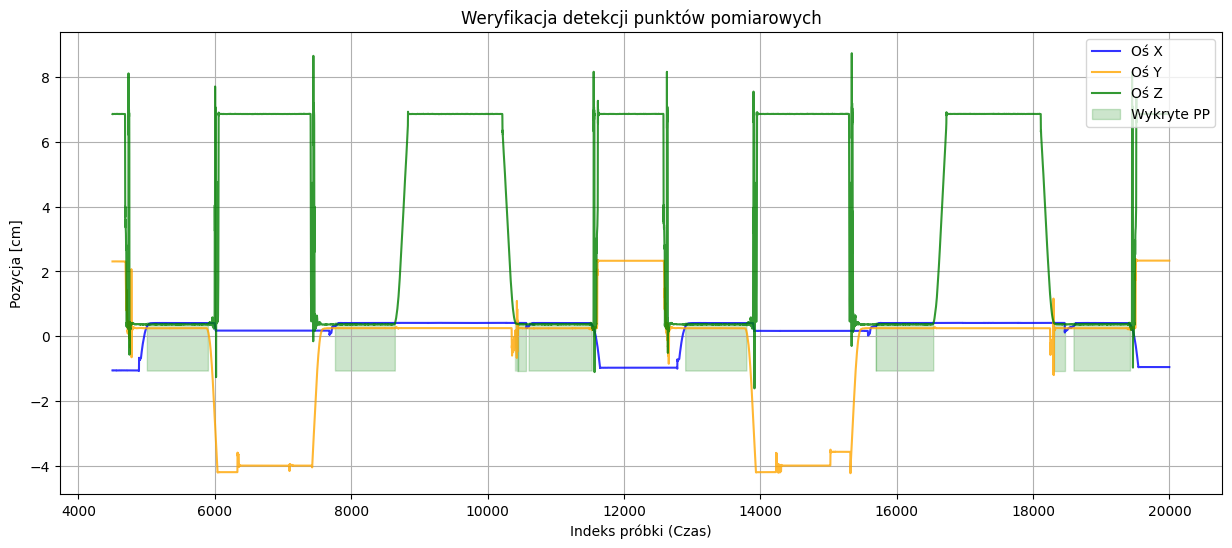

In [14]:
# Komórka 3: Weryfikacja detekcji PP i wizualizacja
start_p, end_p = 4500, 20000
subset = df.iloc[start_p:end_p]

plt.figure(figsize=(15, 6))
plt.plot(subset.index, subset['x'], label='Oś X', color='blue', alpha=0.8)
plt.plot(subset.index, subset['y'], label='Oś Y', color='orange', alpha=0.8)
plt.plot(subset.index, subset['z'], label='Oś Z', color='green', alpha=0.8)

# Zaznaczenie obszarów PP wykrytych przez algorytm
is_pp_subset = subset['is_near_pp']
plt.fill_between(subset.index, subset['x'].min(), subset['x'].max(), 
                 where=is_pp_subset, color='green', alpha=0.2, label='Wykryte PP')

plt.title("Weryfikacja detekcji punktów pomiarowych")
plt.xlabel("Indeks próbki (Czas)")
plt.ylabel("Pozycja [cm]")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [9]:
# Komórka 4: Ekstrakcja punktów pomiarowych
dist_to_center = np.sqrt(((df[['x', 'y', 'z']] - ml_center)**2).sum(axis=1))
is_in_pp = dist_to_center < 0.1 

# Grupowanie ciągłych bloków i filtrowanie sesji krótszych niż 1.5 sekundy (750 próbek)
session_id = (is_in_pp != is_in_pp.shift()).cumsum()
pp_sessions = df[is_in_pp].groupby(session_id).filter(lambda x: len(x) > 750)

final_results = []
for _, group in pp_sessions.groupby(session_id):
    # Odrzucenie 100 próbek marginesu z początku i końca postoju
    stable_data = group.iloc[100:-100] 
    final_results.append({
        'session_no': len(final_results) + 1,
        'start_idx': stable_data.index[0],
        'end_idx': stable_data.index[-1],
        'x_avg': stable_data['x'].mean(), # xi do wzoru
        'y_avg': stable_data['y'].mean(), # yi do wzoru
        'z_avg': stable_data['z'].mean(), # zi do wzoru
        'samples': len(stable_data)
    })

sessions_df = pd.DataFrame(final_results)

print(f"Wykryte wizyty: {len(sessions_df)} / 300")
print(sessions_df.head())

Wykryte wizyty: 300 / 300
   session_no  start_idx  end_idx     x_avg     y_avg     z_avg  samples
0           1       5102     5802  0.407450  0.246843  0.364134      701
1           2       7829     8550  0.406511  0.248657  0.364268      722
2           3      10682    11435  0.407421  0.246069  0.368358      754
3           4      12997    13698  0.406686  0.247622  0.364265      702
4           5      15733    16447  0.406506  0.248806  0.364122      715


# Liczenie Powtarzalności

In [ ]:
# Komórka 5: Obliczanie powtarzalności RP
def calculate_rp_metric(group_df):
    # Średnie położeń rzeczywistych (położenie zadane l_bar)
    x_mean, y_mean, z_mean = group_df['x_avg'].mean(), group_df['y_avg'].mean(), group_df['z_avg'].mean()
    
    # Odległości l_i dla każdego powtórzenia
    distances = np.sqrt(
        (group_df['x_avg'] - x_mean)**2 + 
        (group_df['y_avg'] - y_mean)**2 + 
        (group_df['z_avg'] - z_mean)**2
    )
    
    # Średnia odległość i odchylenie standardowe Sl
    l_bar = distances.mean()
    s_l = np.sqrt(np.sum((distances - l_bar)**2) / (len(distances) - 1))
    return l_bar + 3 * s_l

# Podział na grupy dojazdowe (co trzeci punkt)
group_x, group_y, group_z = sessions_df.iloc[0::3], sessions_df.iloc[1::3], sessions_df.iloc[2::3]

# Obliczanie RP i konwersja cm -> mm
results = {
    "RPx": calculate_rp_metric(group_x) * 10,
    "RPy": calculate_rp_metric(group_y) * 10,
    "RPz": calculate_rp_metric(group_z) * 10
}

print(f"WYNIKI POWTARZALNOŚCI (RP)")
for axis, val in results.items():
    print(f"{axis}: {val:.5f} mm")

WYNIKI POWTARZALNOŚCI (RP)
RPx: 0.02055 mm
RPy: 0.02543 mm
RPz: 0.01997 mm
----------------------------------
Specyfikacja KUKA: ±0.03 mm
